# Predicting Revenue from Parking Citations in Baltimore
Capstone Project for Springboard Data Science Bootcamp

Tamara Monge

### Section 4: Prediction


In [1]:
# Import standard libraries
# analysis
import pandas as pd
import numpy as np
from datetime import datetime, date
from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# plotting
import matplotlib.pyplot as plt
%matplotlib inline 

# supervised learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.externals import joblib
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score   
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Import prepared feature array
X = pd.read_csv('persistence/features_2018-05-22.csv')
X.drop(['date'], axis=1, inplace=True)

# Import prepared target vector
y = pd.read_csv('persistence/target_2018-05-22.csv', header=None).iloc[:,1]

print('Guessing all ones (all citations were paid) results in a ', round(100*y.sum()/y.count()),'% success rate.')
print('Can models do better?')

Guessing all ones (all citations were paid) results in a  67.0 % success rate.
Can models do better?


In [3]:
# Normalize/scale data
Xscaled = scale(X)

# Split data for training and testing 70%/30%
Xtrain, Xtest, ytrain, ytest = train_test_split(Xscaled, y, train_size=0.7, random_state=42)


### A) Logistic Regression


In [4]:
# ### Uncomment this section to train model from scratch ####
# # GridSearch Cross Validation to find best hyperparameters
# logreg_params = {'C': [0.01, 0.1, 1, 10, 100]}
# logreg = GridSearchCV(LogisticRegression(), logreg_params, cv=5, scoring=make_scorer(accuracy_score))
# start = time()
# logreg.fit(Xtrain, ytrain)  
# print('Training took ', time()-start, 'seconds.')
# print('Best parameters:',logreg.best_params_)
# print('Best score:', logreg.best_score_)

# # Save the trained model 
# filename = 'persistence/logreg_' + str(date.today()) + '.sav'
# joblib.dump(logreg, filename)

Predicting took  0.15844511985778809 seconds.

Logistic Regression
Accuracy: 0.749913084407
Precision: 0.792372818747
Recall: 0.851850969366
F1: 0.821036112759
Confusion Matrix:
[[ 32952  28104]
 [ 18653 107254]]
Classification Report:
             precision    recall  f1-score   support

          0       0.64      0.54      0.58     61056
          1       0.79      0.85      0.82    125907

avg / total       0.74      0.75      0.74    186963


ROC AUC for LogReg model: 0.784249971983


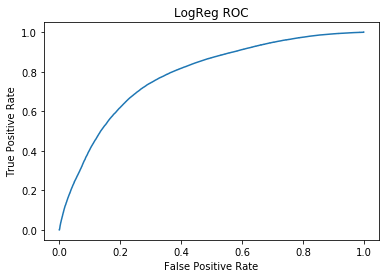

In [5]:
# Load trained model from disk
filename = 'persistence/logreg_2018-05-13.sav'
logreg = joblib.load(filename)

# Predict
start = time()
ypred_logreg = logreg.predict(Xtest)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('Logistic Regression')
print('====================')
print('Accuracy:',accuracy_score(ytest, ypred_logreg))
print('Precision:',precision_score(ytest, ypred_logreg))
print('Recall:', recall_score(ytest, ypred_logreg))
print('F1:', f1_score(ytest, ypred_logreg))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred_logreg))
print('Classification Report:')
print(classification_report(ytest, ypred_logreg))
print('')

# ROC
ypredprob_logreg = logreg.predict_proba(Xtest)[:,1]
fpr_logreg, tpr_logreg, thresholds = roc_curve(ytest, ypredprob_logreg)
_ = plt.plot(fpr_logreg, tpr_logreg)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('LogReg ROC')
print('ROC AUC for LogReg model:',roc_auc_score(ytest,ypredprob_logreg))

### B) Linear SVC

In [6]:
#### Uncomment this section to train model from scratch ####
# # GridSearch Cross Validation to find best hyperparameters
# lsvc_params =  {"C":[0.01, 0.1, 1, 10, 100]}
# lsvc = GridSearchCV(LinearSVC(), lsvc_params, n_jobs=4, cv=5, scoring=make_scorer(accuracy_score))
# start = time()
# lsvc.fit(Xtrain, ytrain)  
# print('Training took ', time()-start, 'seconds.')
# print('Best parameters:', lsvc.best_params_)
# print('Best score:', lsvc.best_score_)

# # Save the trained model 
# filename = 'persistence/lsvc_'+ str(date.today()) + '.sav'
# joblib.dump(lsvc, filename)

In [7]:
# Load trained model from disk
filename = 'persistence/lsvc_2018-05-13.sav'
lsvc = joblib.load(filename)

# Predict
start = time()
ypred_lsvc = lsvc.predict(Xtest)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('Linear SVC')
print('====================')
print('Accuracy:',accuracy_score(ytest, ypred_lsvc))
print('Precision:',precision_score(ytest, ypred_lsvc))
print('Recall:', recall_score(ytest, ypred_lsvc))
print('F1:', f1_score(ytest, ypred_lsvc))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred_lsvc))
print('Classification Report:')
print(classification_report(ytest, ypred_lsvc))
print('')

# ROC -- use lsvc.decision_function 

Predicting took  0.056137800216674805 seconds.

Linear SVC
Accuracy: 0.747329685553
Precision: 0.789999483901
Recall: 0.851024962869
F1: 0.819377533073
Confusion Matrix:
[[ 32573  28483]
 [ 18757 107150]]
Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.53      0.58     61056
          1       0.79      0.85      0.82    125907

avg / total       0.74      0.75      0.74    186963




### C) SVC with RBF Kernel


Fitting the RBF-SVC on the entire feature array is untennable (didn't finish in 14 days). 
To work around this, let's select a manageable number (20-30) of the most important features based on the coefficients returned from the logistic regression classifier. 

In [8]:
# Train the logreg    
clf = LogisticRegression(C=1)
clf.fit(Xtrain, ytrain)

# Put the coefficients in a dataframe
df_features = pd.DataFrame({'features':np.array(X.columns), 'coefficients':clf.coef_[0,:]})
df_features.sort_values('coefficients', ascending=False)

# Determine which threshold to use to get a manageable number of features (20-30)
(abs(df_features.coefficients) >= 0.5).sum()
(abs(df_features.coefficients) >= 0.2).sum()
(abs(df_features.coefficients) >= 0.1).sum()
(abs(df_features.coefficients) >= 0.07).sum()
(abs(df_features.coefficients) >= 0.05).sum()

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

,coefficients,features
317,1.041197,desc_ALL OTHER PARKING METER VIOLATIONS
325,0.733007,desc_FIXED SPEED CAMERA
335,0.728980,desc_NO STOPPING/STANDING NOT TOW-AWAY ZONE
331,0.628087,desc_NO STOP/PARK STREET CLEANING
336,0.625778,desc_NO STOPPING/STANDING TOW AWAY ZONE
340,0.606305,desc_RESIDENTIAL PARKING PERMIT ONLY
318,0.421780,desc_ALL OTHER STOPPING OR PARKING VIOLATIONS
323,0.337496,desc_EXPIRED TAGS
338,0.307880,desc_OBSTRUCT/IMPEDING MOVEMENT OF PEDESTRIAN
327,0.298808,desc_IN TRANSIT ZONE/STOP


8

21

30

33

42

It seems like a threshold of >= 0.2 will suffice.

In [9]:
# Identify the top 21 features from LogReg
df_select21 = df_features[abs(df_features.coefficients) >= 0.2]
df_select21

# Extract only the 21 identified features
X21 = X[df_select21.features]
X21.shape

# Normalize/scale 
X21scaled = scale(X21)

# Split data for training-testing 70%-30%
X21train, X21test, y21train, y21test = train_test_split(X21scaled, y, train_size=0.7, random_state=42)

,coefficients,features
0,0.214587,instate
317,1.041197,desc_ALL OTHER PARKING METER VIOLATIONS
318,0.421780,desc_ALL OTHER STOPPING OR PARKING VIOLATIONS
323,0.337496,desc_EXPIRED TAGS
325,0.733007,desc_FIXED SPEED CAMERA
327,0.298808,desc_IN TRANSIT ZONE/STOP
329,0.225227,desc_LESS THAN 15 FEET FROM FIRE HYDRANT
331,0.628087,desc_NO STOP/PARK STREET CLEANING
334,0.229020,desc_NO STOPPING//PARKING STADIUM EVENT CAMDEN
335,0.728980,desc_NO STOPPING/STANDING NOT TOW-AWAY ZONE


(623208, 21)

Now that we have the pared-down feature array, let's train the svc.

In [10]:
#### Uncomment this section to train model from scratch ####
# # GridSearch Cross Validation to find best hyperparameters
# svc_params =  {"C":[0.01, 0.1, 1, 10, 100], "gamma":[0.25, 0.5, 0.75]}
# svc21 = GridSearchCV(SVC(), svc_params, n_jobs=4, cv=5, scoring=make_scorer(accuracy_score))
# start = time()
# svc21.fit(X21train, y21train)
# print(time()-start)
# print('Training took ', time()-start, 'seconds.')
# print('Best parameters:', svc21.best_params_)
# print('Best score:', svc21.best_score_)

# # Save the trained model 
# filename = 'persistence/svc21_'+ str(date.today()) + '.sav'
# joblib.dump(svc21, filename)

In [11]:
# Load trained model from disk
filename = 'persistence/svc21_2018-05-17.sav'
svc21 = joblib.load(filename)

# Predict
start = time()
ypred_svc21 = svc21.predict(X21test)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('RBF SVC (21 features)')
print('====================')
print('Accuracy:',accuracy_score(y21test, ypred_svc21))
print('Precision:',precision_score(y21test, ypred_svc21))
print('Recall:', recall_score(y21test, ypred_svc21))
print('F1:', f1_score(y21test, ypred_svc21))
print('Confusion Matrix:')
print(confusion_matrix(y21test, ypred_svc21))
print('Classification Report:')
print(classification_report(y21test, ypred_svc21))
print('')

# Decided not to use ROC AUC score as a metric for SVM because 
# training model with the probabilty=True flag makes the train time excessively 
# long (more than 8 days).

Predicting took  1195.791552066803 seconds.

RBF SVC (21 features)
Accuracy: 0.74729224499
Precision: 0.789950163664
Recall: 0.85104084761
F1: 0.819358366055
Confusion Matrix:
[[ 32564  28492]
 [ 18755 107152]]
Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.53      0.58     61056
          1       0.79      0.85      0.82    125907

avg / total       0.74      0.75      0.74    186963




###  D) Decision Tree

In [12]:
#### Uncomment this section to train model from scratch ####
# # GridSearch Cross Validation to find best hyperparameters
# dtc_params =  {"max_depth":[5, 10, 30, 50, 100]}
# dtc = GridSearchCV(DecisionTreeClassifier(), dtc_params, n_jobs=4, cv=5, scoring=make_scorer(accuracy_score))
# start = time()
# dtc.fit(Xtrain, ytrain)  
# print('Training took ', time()-start, 'seconds.')
# print('Best parameters:', dtc.best_params_)
# print('Best score:', dtc.best_score_)

# # Save the trained model 
# filename = 'persistence/dtc_'+ str(date.today()) + '.sav'
# joblib.dump(dtc, filename)

In [13]:
# Load trained model from disk
filename = 'persistence/dtc_2018-05-20.sav'
dtc = joblib.load(filename)

# Predict
start = time()
ypred_dtc = dtc.predict(Xtest)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('Decision Tree')
print('====================')
print('Accuracy:',accuracy_score(ytest, ypred_dtc))
print('Precision:',precision_score(ytest, ypred_dtc))
print('Recall:', recall_score(ytest, ypred_dtc))
print('F1:', f1_score(ytest, ypred_dtc))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred_dtc))
print('Classification Report:')
print(classification_report(ytest, ypred_dtc))

Predicting took  2.096376895904541 seconds.
Decision Tree
Accuracy: 0.754020849045
Precision: 0.77966042384
Recall: 0.884787978429
F1: 0.828904241585
Confusion Matrix:
[[ 29573  31483]
 [ 14506 111401]]
Classification Report:
             precision    recall  f1-score   support

          0       0.67      0.48      0.56     61056
          1       0.78      0.88      0.83    125907

avg / total       0.74      0.75      0.74    186963



### E) Random Forest

In [14]:
#### Uncomment this section to train model from scratch ####
# # GridSearch Cross Validation to find best hyperparameters
# rfc_params =  {"max_depth":[5, 10, 30, 50, 100], "n_estimators":[5, 10, 25, 50], "min_samples_leaf":[1, 2, 4, 7, 10]}
# # (max_depth=10, n_estimators=10, max_features=100)
# rfc = GridSearchCV(RandomForestClassifier(random_state=42), rfc_params, n_jobs=4, cv=5, scoring=make_scorer(accuracy_score))
# start = time()
# rfc.fit(Xtrain, ytrain)  
# print('Training took ', time()-start, 'seconds.')
# print('Best parameters:', rfc.best_params_)
# print('Best score:', rfc.best_score_)

# # Save the trained model
# filename = 'persistence/rfc_'+ str(date.today()) + '.sav'
# joblib.dump(rfc, filename)

In [15]:
# Load trained model from disk
filename = 'persistence/rfc_2018-05-20.sav'
rfc = joblib.load(filename)

# Predict
start = time()
ypred_rfc = rfc.predict(Xtest)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('Random Forest')
print('====================')
print('Accuracy:',accuracy_score(ytest, ypred_rfc))
print('Precision:',precision_score(ytest, ypred_rfc))
print('Recall:', recall_score(ytest, ypred_rfc))
print('F1:', f1_score(ytest, ypred_rfc))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred_rfc))
print('Classification Report:')
print(classification_report(ytest, ypred_rfc))

Predicting took  3.1491219997406006 seconds.
Random Forest
Accuracy: 0.767189229955
Precision: 0.785091362126
Recall: 0.900903047487
F1: 0.839019627423
Confusion Matrix:
[[ 30006  31050]
 [ 12477 113430]]
Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.49      0.58     61056
          1       0.79      0.90      0.84    125907

avg / total       0.76      0.77      0.75    186963



### F) Naive Bayes


In [16]:
#### Uncomment this section to train model from scratch ####
# # Fit the model
# gnb = GaussianNB()
# start = time()
# gnb.fit(Xtrain, ytrain)  
# print('Training took ', time()-start, 'seconds.')

# # Save the trained model 
# filename = 'persistence/gnb_'+ str(date.today()) + '.sav'
# joblib.dump(gnb, filename)

In [18]:
# Load trained model from disk
filename = 'persistence/gnb_2018-05-20.sav'
gnb = joblib.load(filename)
gnb.get_params()

# Predict
start = time()
ypred_gnb = gnb.predict(Xtest)
print('Predicting took ', time()-start, 'seconds.')
print('')

# Performance Metrics
print('Naive Bayes')
print('====================')
print('Accuracy:',accuracy_score(ytest, ypred_gnb))
print('Precision:',precision_score(ytest, ypred_gnb))
print('Recall:', recall_score(ytest, ypred_gnb))
print('F1:', f1_score(ytest, ypred_gnb))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred_gnb))
print('Classification Report:')
print(classification_report(ytest, ypred_gnb))

{'priors': [0.33, 0.67]}

Predicting took  2.0376381874084473 seconds.

Naive Bayes
Accuracy: 0.32820932484
Precision: 0.764199655766
Recall: 0.00352641235197
F1: 0.00702042881538
Confusion Matrix:
[[ 60919    137]
 [125463    444]]
Classification Report:
             precision    recall  f1-score   support

          0       0.33      1.00      0.49     61056
          1       0.76      0.00      0.01    125907

avg / total       0.62      0.33      0.17    186963

